<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />

This notebook is prepared as part of the GEOS 636 class project by [Amrit Thapa](https://amrit-thapa-2044.github.io/). It  enables users to explore freely available UNAVCO GPS stations within their area of interest.

# 1. Install and load required package
While Google Colab comes with many pre-installed packages, users need to install some additional packages themselves. In this notebook, we will be using the 'pygmtsar' package, which requires manual installation. To do so, we first need to install 'conda.' Execute the code cell below to install 'conda' and 'pygmtsar.' Please note that this process may take some time.

After the packages are installed, we will load all the necessary ones.







In [ ]:

!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local
!conda update conda -y -q
!conda config --prepend channels conda-forge
!conda install -q -y --prefix /usr/local python=3.8 pygmt

import sys
import os
sys.path.append('/usr/local/lib/python3.8/site-packages')
os.environ["GMT_LIBRARY_PATH"]="/usr/local/lib"

--2023-12-08 06:31:53--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120986213 (115M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 115.38M   155MB/s    in 0.7s    

2023-12-08 06:31:54 (155 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [120986213/120986213]

PREFIX=/usr/local
Unpacking payload ...
                                                                                 
Installing base environment...





Preparing transaction: - \ | / - done
Executing transaction: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
installation finishe

In [ ]:
import warnings
import requests
import pandas as pd
import io
import os
import pygmt
import numpy as np

from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt


# 2. Function to map UNAVCO station

UNAVCO offers complimentary access to GPS observations from across the globe. These GPS data can be utilized for analyzing surface deformation. The function map_GPS_UNAVCO provided below enables users to generate a map displaying all accessible UNAVCO GPS stations. It requires five arguments:

xmin: the minimum longitude of your area in WGS84.

xmax: the maximum longitude of your area in WGS84.

ymin: the minimum latitude of your area in WGS84.

ymax: the maximum latitude of your area in WGS84.

In [ ]:
def map_GPS_UNAVCO(xmin,xmax,ymin,ymax,fname,dpi):
  url = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
  r = requests.get(url)

  # Read data into Pandas DataFrame
  df = pd.read_csv(io.StringIO(r.text),sep="\s+",engine='python',on_bad_lines='skip')

  # Filter stations by geographic bounds
  df_my_ext = df[(df['Lat(deg)'] >= ymin) &
                   (df['Lat(deg)'] <= ymax) &
                   (df['Long(deg)'] >= xmin) &
                   (df['Long(deg)'] <= xmax)]

  fig = pygmt.Figure()
  fig.coast(region=[xmin, xmax, ymin,ymax], land='#C4A484', water="skyblue",projection="M0/0/12c",shorelines=True)
  fig.coast(borders=["1/2p,green"],map_scale="n0.2/0.075+l+w200")
  fig.basemap(
      frame=["WStr", "xa2f2", "ya2f2"],
    )
  fig.basemap(frame=["a", '+t"UNAVCO GPS STATIONS"'])
  fig.plot(x=df['Long(deg)'].tolist(), y=df['Lat(deg)'].tolist(),style="i.3c", fill="blue")
  fig.text(text='n:'+str(df_my_ext.shape[0]),position="TR",font="14p,Helvetica-Bold,black",justify="TR")
  fig.show()
  fig.savefig(fname,dpi=dpi)

Let's make a map of all available UNAVCO GPS station in and around Nepal.
We simply need to provide extent of Nepal.

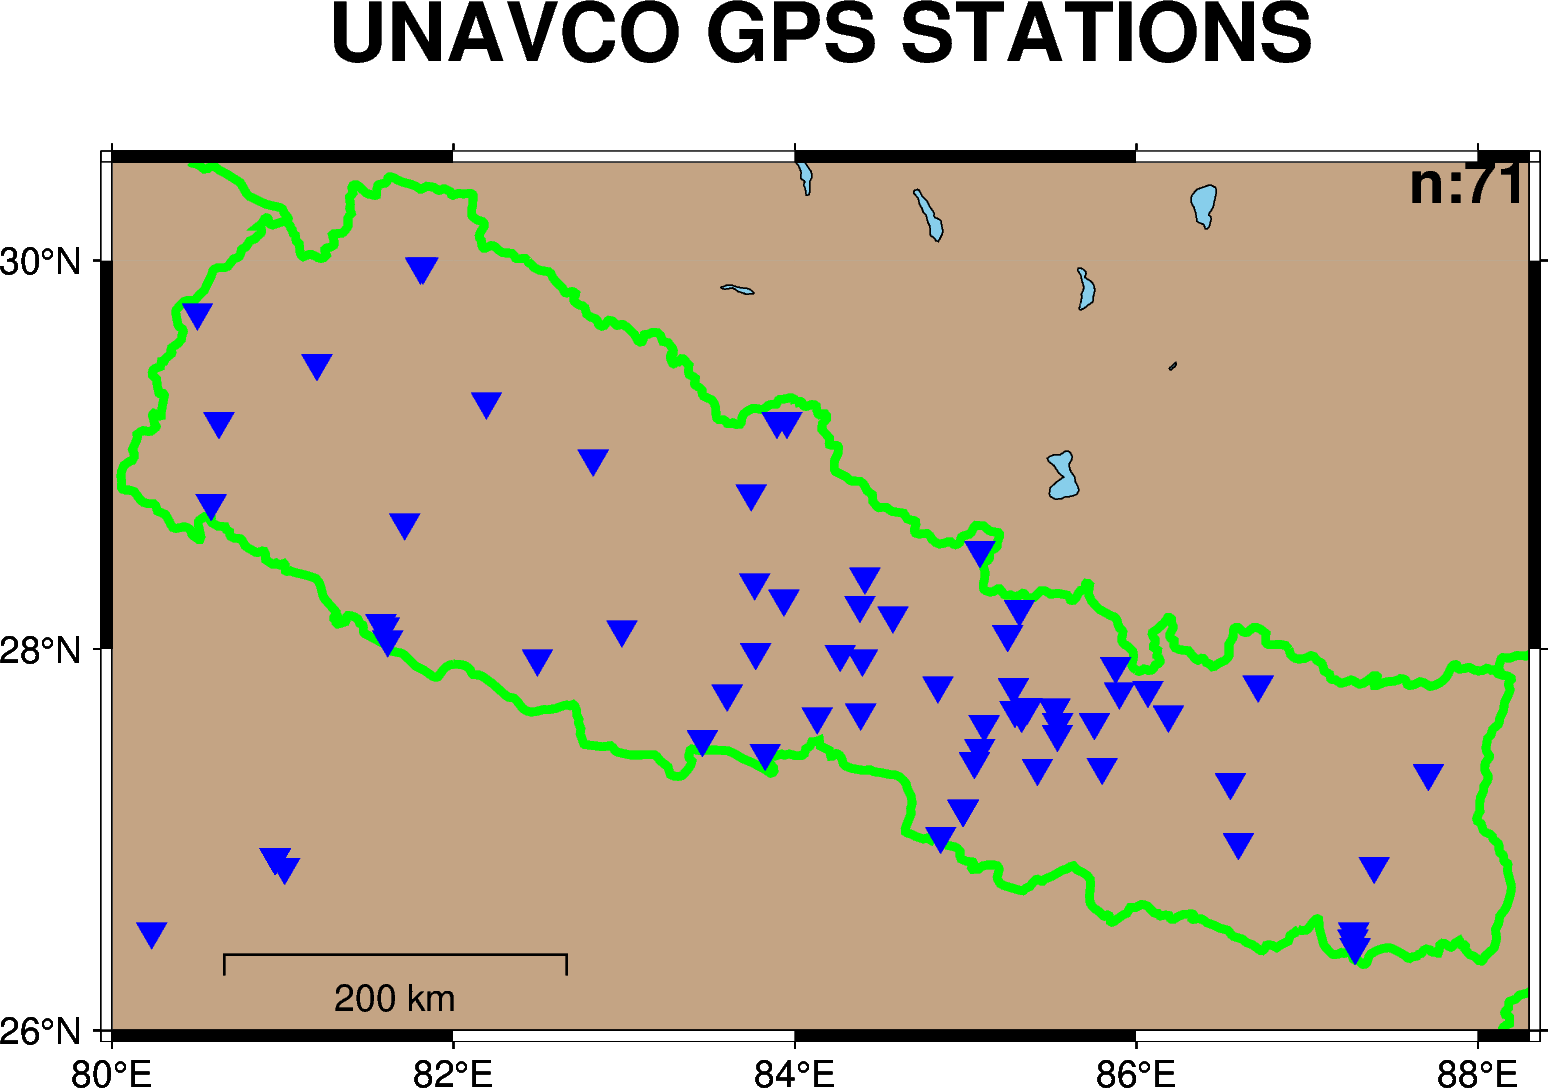

In [ ]:
# extent of area of interest
xmin=80
xmax=88.3
ymin=26
ymax=30.5

map_GPS_UNAVCO(xmin,xmax,ymin,ymax,'test.jpg',350)

# 3. Function to download UNAVCO GPS Data from multiple stations

The function defined above, map_GPS_UNAVCO, specifically generates a map for a chosen area of interest but does not handle data downloading. For users who wish to download all available GPS data within their study site, the provided function download_UNAVCO_GPS below can be utilized.

This function requires four arguments: xmin and xmax represent the minimum and maximum longitudes of your area, while ymin and ymax represent the minimum and maximum latitudes in WGS84.


In [ ]:
def download_UNAVCO_GPS(xmin, xmax, ymin, ymax):

    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    # Download station data file
    url = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
    r = requests.get(url)

    # Read data into Pandas DataFrame
    df = pd.read_csv(io.StringIO(r.text),sep="\s+",engine='python',on_bad_lines='skip')

    # Filter stations by geographic bounds
    df_my_ext = df[(df['Lat(deg)'] >= ymin) &
                   (df['Lat(deg)'] <= ymax) &
                   (df['Long(deg)'] >= xmin) &
                   (df['Long(deg)'] <= xmax)]

    # Extract station codes
    station_codes = df_my_ext['Sta'].tolist()

    # Iterate over stations
    for station in station_codes:

        # Build filename
        filename = f"{station}.tenv3"

        # Check if file already downloaded
        if not os.path.exists(filename):

            # Download file via wget
            url = f"http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/{filename}"
            # os.system(f"wget {url}")
            os.system(f"wget {url} > /dev/null 2>&1")

            # Process file with awk
            os.system(f"awk '{{print $2, $3, $9, $11, $13}}' {filename} > {station}_YYYY.YYYY_ENU.txt")
            print(f"Downloaded and processed data for {station}")
            os.remove(filename)
        else:
            print(f"{filename} already exists, skipping download")

The following code cell demonstrate how to use download_UNAVCO_GPS function.

In [ ]:
download_UNAVCO_GPS(xmin,xmax,ymin,ymax)

Downloaded and processed data for AIRP
Downloaded and processed data for BELT
Downloaded and processed data for BESI
Downloaded and processed data for BGNJ
Downloaded and processed data for BIRP
Downloaded and processed data for BMCL
Downloaded and processed data for BNDP
Downloaded and processed data for BRN2
Downloaded and processed data for BRNG
Downloaded and processed data for BRWA
Downloaded and processed data for BTNI
Downloaded and processed data for BYNA
Downloaded and processed data for CHLM
Downloaded and processed data for CHWN
Downloaded and processed data for DAMA
Downloaded and processed data for DLPA
Downloaded and processed data for DMAU
Downloaded and processed data for DNC4
Downloaded and processed data for DNGD
Downloaded and processed data for DNSG
Downloaded and processed data for DRCL
Downloaded and processed data for GHER
Downloaded and processed data for GNTW
Downloaded and processed data for GOMT
Downloaded and processed data for GRHI
Downloaded and processed 

# Function to know GPS data from nearest UNAVCO station
Sometime user may want to use single GPS station which is closest to their study site. The following function allows users to know the nearest station. It takes two arguments: latitude and longitude of their study site. The function will provides name of nearest GPS station.

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

def nearest_UNAVC_GPS(user_latitude,user_longitude):
  url = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
  r = requests.get(url)

  # Read data into Pandas DataFrame
  data = pd.read_csv(io.StringIO(r.text),sep="\s+",engine='python',on_bad_lines='skip')
  data = data.rename(columns={'Lat(deg)': 'latitude', 'Long(deg)': 'longitude'})

  # Calculate distances and add a new column 'distance' to the DataFrame
  data['distance'] = data.apply(lambda row: haversine(user_latitude, user_longitude, row['latitude'], row['longitude']), axis=1)

  # Find the row with the minimum distance
  nearest_point = data.loc[data['distance'].idxmin()]

  # Drop the 'distance' column before returning the result
  nearest_point = nearest_point.drop('distance')

  return nearest_point

We often used GPS data to validate InSAR data. While GPS provide dispalcement in all three dimention [East, North and vertical] but InSAR does not. Either we have to combine InSAR odservation from different direction to derive the vertical displacement or we have to project GPS velocity to line of sight direction. The following function convertsdoes this.. It takes latitude and longitude from users and find nearest UNAVCO GPS station and derives LOS displacment

In [ ]:
def LOS(E_D,N_D,U_D,inc_angle,az_angle):
  v_los = (  E_D * np.sin(np.deg2rad(inc_angle)) * np.sin(np.deg2rad(az_angle)) * -1
             + N_D * np.sin(np.deg2rad(inc_angle)) * np.cos(np.deg2rad(az_angle))
             + U_D * np.cos(np.deg2rad(inc_angle)))
  return(v_los)

In [ ]:
def LOS_from_UNAVCO(user_latitude,user_longitude,inc_angle,az_angle):
    nearest_point=nearest_UNAVC_GPS(user_latitude,user_longitude)
    station=nearest_point['Sta']
    filename = f"{station}.tenv3"

    if not os.path.exists(filename):
        url = f"http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/{filename}"
        # Download the data using wget
        !wget "$url"

        # Use awk to select specific columns [1,3,9,11,13] and write to a new file
        os.system(f"awk '{{print $2, $3, $9, $11, $13}}' {filename} > {station}_YYYY.YYYY_ENU.txt")

        print(f"Downloaded and processed data for {station}")
    else:
        print(f"{filename} already exists, skipping download")

    filename_txt = f"{station}_YYYY.YYYY_ENU.txt"
    # read modified text as panda
    gnss_ts = pd.read_csv(filename_txt, delim_whitespace=True)

    LOS_D=LOS(gnss_ts['__east(m)'],gnss_ts['_north(m)'],gnss_ts['____up(m)'],inc_angle,az_angle)
    gnss_ts['LOS']=LOS_D
    gnss_ts.to_csv(f'{station}_EWU_LOS_DISP.csv', index=False)
    return gnss_ts

In [ ]:
df=LOS_from_UNAVCO(26,82,30,12)
df.head()

--2023-12-08 06:37:31--  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/GOMT.tenv3
Resolving geodesy.unr.edu (geodesy.unr.edu)... 134.197.38.53
Connecting to geodesy.unr.edu (geodesy.unr.edu)|134.197.38.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1224 (1.2K)
Saving to: ‘GOMT.tenv3’

GOMT.tenv3          100%[===================>]   1.20K  --.-KB/s    in 0s      

2023-12-08 06:37:31 (224 MB/s) - ‘GOMT.tenv3’ saved [1224/1224]

Downloaded and processed data for GOMT


,YYMMMDD,yyyy.yyyy,__east(m),_north(m),____up(m),LOS
0,21SEP12,2021.6975,0.334677,0.840419,0.137536,0.495345
1,21SEP14,2021.7029,0.332131,0.837200,0.131795,0.489063
2,21SEP16,2021.7084,0.338280,0.836671,0.114949,0.473576
3,21SEP17,2021.7112,0.332921,0.838271,0.125888,0.484390
4,21SEP18,2021.7139,0.334041,0.836210,0.125806,0.483194


# Function to plot GPS displacement and LOS displacemnt
This function plots GPS data and LOS displacements. It takes latitude and longitude from users and find nearest UNAVCO GPS station and derives LOS displacment and plot as graphs together with GPS displacement in all three directions.

In [ ]:
def plot_EWU_LOS(user_latitude,user_longitude,inc_angle,az_angle):
  df=LOS_from_UNAVCO(user_latitude,user_longitude,inc_angle,az_angle)
  # Create subplots for x, y, and z
  plt.figure(figsize=(8, 5))

  plt.subplot(411)
  plt.plot(df['yyyy.yyyy'],df['__east(m)'], label='East Displacement (mm)',color='red')
  plt.ylabel('East (m)')

  plt.subplot(412)
  plt.plot(df['yyyy.yyyy'],df['_north(m)'], label='North Displacement (mm)',color='green')
  plt.ylabel('North (m)')
  # plt.legend()

  plt.subplot(413)
  plt.plot(df['yyyy.yyyy'],df['____up(m)'], label='Vertical Displacement (mm)',color='blue')
  plt.ylabel('Up (m)')

  plt.subplot(414)
  plt.plot(df['yyyy.yyyy'],df['LOS'], label='Vertical Displacement (mm)',color='blue')
  plt.xlabel('Year')
  plt.ylabel('LOS (m)')

  # Improve layout with tight layout
  plt.tight_layout()

  # Show the plot
  plt.show()


--2023-12-08 06:37:32--  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/NAST.tenv3
Resolving geodesy.unr.edu (geodesy.unr.edu)... 134.197.38.53
Connecting to geodesy.unr.edu (geodesy.unr.edu)|134.197.38.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435948 (426K)
Saving to: ‘NAST.tenv3’

NAST.tenv3          100%[===================>] 425.73K  1.42MB/s    in 0.3s    

2023-12-08 06:37:32 (1.42 MB/s) - ‘NAST.tenv3’ saved [435948/435948]

Downloaded and processed data for NAST


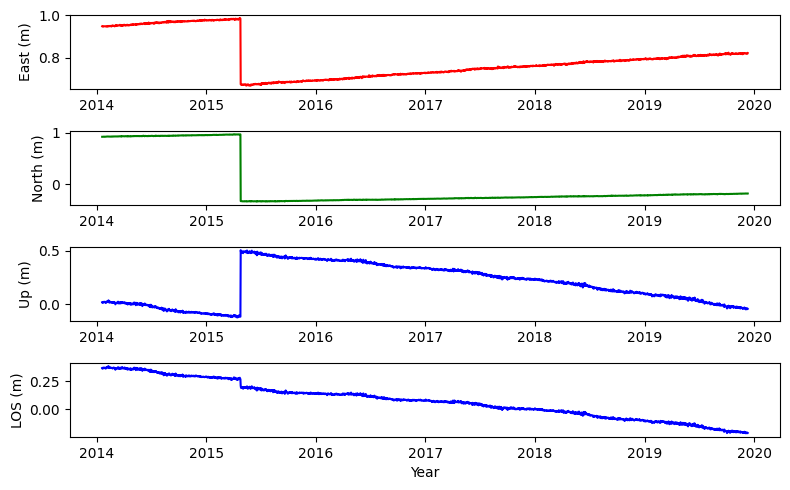

In [ ]:
plot_EWU_LOS(27.6515,85.3278,30,12)

--2023-12-08 06:37:35--  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/KIRT.tenv3
Resolving geodesy.unr.edu (geodesy.unr.edu)... 134.197.38.53
Connecting to geodesy.unr.edu (geodesy.unr.edu)|134.197.38.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378828 (370K)
Saving to: ‘KIRT.tenv3’

KIRT.tenv3          100%[===================>] 369.95K  1.22MB/s    in 0.3s    

2023-12-08 06:37:36 (1.22 MB/s) - ‘KIRT.tenv3’ saved [378828/378828]

Downloaded and processed data for KIRT


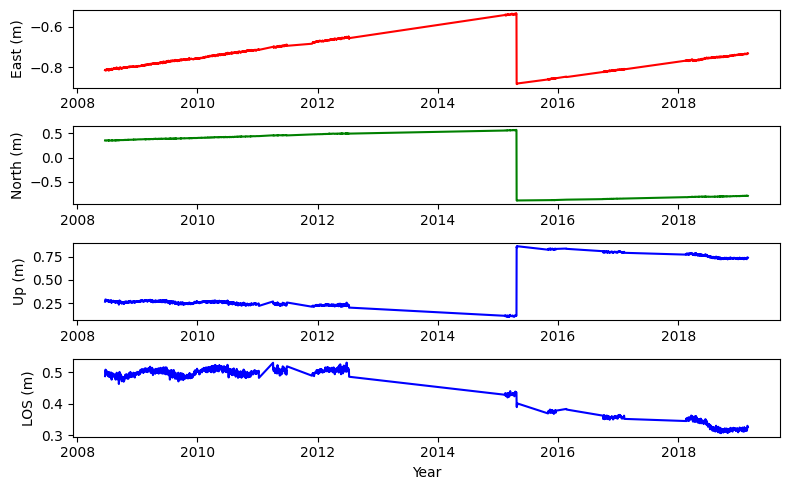

In [ ]:
plot_EWU_LOS(27.681023, 85.282433,30,12)